In [22]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets

In [23]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
class ReadDataCSV(Dataset):
    def __init__(self, csv_file_path, train=True, transform=None):
        data = pd.read_csv(csv_file_path)

        raw = data.to_numpy
        num_images = data.shape[0]
        image_as_array = data.values[:,1:]
        label_as_array = data.values[:,0]
        self.images_numpy = image_as_array.reshape(num_images, 150, 150, 3)
        self.targets = label_as_array
        self.transform = transform
    
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.images_numpy[index], self.targets[index]
        img = img.squeeze().astype(np.uint8)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)
        target = torch.tensor(target)
        return img, target

In [25]:
dataset = ReadDataCSV("test_data.csv",transform=img_transform)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


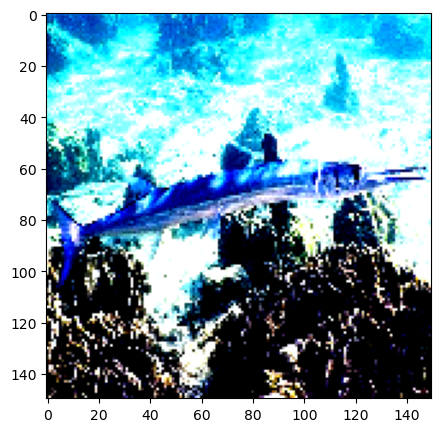

In [26]:
[imgs,labels] = (next(iter(dataloader)))
imgs = np.squeeze(imgs)
plt.figure(figsize=(5,5))
plt.imshow(imgs[0].permute(1,2,0).cpu().numpy())

In [28]:
train_dataset = ReadDataCSV("train_data.csv",transform=img_transform)
test_dataset = ReadDataCSV("test_data.csv",transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [29]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN Class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 34 * 34, 120)

        self.fc2 = nn.Linear(120, 120)

        self.fc3 = nn.Linear(120, 16)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
 
        batch_size = x.size(0)
        flattened_size = x.size(1) * x.size(2) * x.size(3)
        self.fc1 = nn.Linear(flattened_size, 120)

        x = x.view(batch_size, -1)

        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [38]:


net = Net()

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)
accuracy_values=[]
epoch_number=[]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



for epoch in range(25):

    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs,labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    print(f"Epoch [{epoch+1}/{25}], Loss: {running_loss / len(train_dataloader.dataset)}")

    ##model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    TestAccuracy = 100 * correct / total
    epoch_number += [epoch+1]
    accuracy_values += [TestAccuracy]        
    print("correct: " + str(correct))
    accuracy = 100 * correct / total
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

Epoch [1/25], Loss: 2.784977129977135
correct: 7
Accuracy on test set after epoch 1: 5.07%
Epoch [2/25], Loss: 2.7811639733833844
correct: 10
Accuracy on test set after epoch 2: 7.25%
Epoch [3/25], Loss: 2.779120986611143
correct: 14
Accuracy on test set after epoch 3: 10.14%
Epoch [4/25], Loss: 2.772513700397101
correct: 9
Accuracy on test set after epoch 4: 6.52%
Epoch [5/25], Loss: 2.7696441038213546
correct: 14
Accuracy on test set after epoch 5: 10.14%
Epoch [6/25], Loss: 2.763446533247189
correct: 8
Accuracy on test set after epoch 6: 5.80%
Epoch [7/25], Loss: 2.759781774514579
correct: 8
Accuracy on test set after epoch 7: 5.80%
Epoch [8/25], Loss: 2.752921493139991
correct: 7
Accuracy on test set after epoch 8: 5.07%
Epoch [9/25], Loss: 2.7507460085865687
correct: 8
Accuracy on test set after epoch 9: 5.80%
Epoch [10/25], Loss: 2.739356418647388
correct: 8
Accuracy on test set after epoch 10: 5.80%
Epoch [11/25], Loss: 2.740237885969307
correct: 8
Accuracy on test set after epo

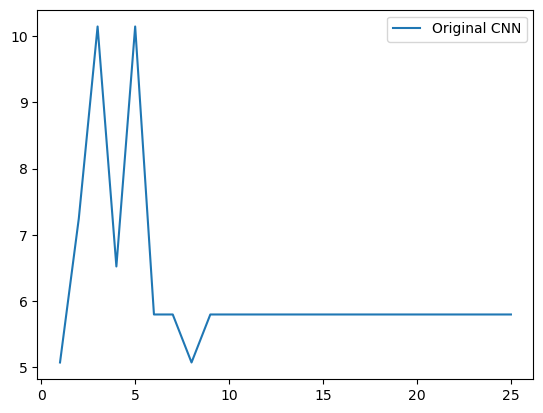

In [39]:
import matplotlib.pyplot as plt


plt.plot(epoch_number, accuracy_values, label="Original CNN")

# Add a legend
plt.legend()

# Show the plot
plt.show()